##Import

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks

import matplotlib.pyplot as plt
import pickle 
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, confusion_matrix
import os


print("Tensorflow version %s" %tf.__version__)

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Tensorflow version 2.8.0
Libraries imported.


##Load dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

datadir = '/content/drive/My Drive/Biometrics Systems'
# trainingset = datadir + '/train/'
dataset_dir = datadir + '/AMI_cropped/'
testset_dir = datadir + '/testset/'
models_dir = datadir + '/models/'
results_dir = datadir + '/results/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model = keras.models.load_model(filename)
    print("\nModel loaded from file %s\n" %filename)
    return model

def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)


# level of data augmentation [0: none, 1: low, 2: high ]
data_augmentation_level = 2

batch_size = 64
input_shape = ()

if data_augmentation_level==0:
    datagen = ImageDataGenerator(
        validation_split=0.3,
        rescale = 1. / 255)
    train_shuffle = False

elif data_augmentation_level==1:
    datagen = ImageDataGenerator(
        validation_split=0.3,
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=10)
    train_shuffle = False

else:    
    datagen = ImageDataGenerator(
        validation_split=0.3,
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=20,\
        width_shift_range=0.1,\
        height_shift_range=0.1,\
        horizontal_flip=True,\
        vertical_flip=False)
    train_shuffle = True

train_generator = datagen.flow_from_directory(
    directory=dataset_dir,
    # directory=testset_dir,
    subset='training',
    target_size=(176, 123),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=train_shuffle)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = datagen.flow_from_directory(
    directory=dataset_dir,
    # directory=testset_dir,
    subset='validation',
    target_size=(176, 123),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

test_datagen2 = ImageDataGenerator(
    rescale = 1. / 255)

test_generator2 = test_datagen2.flow_from_directory(
    directory=dataset_dir,
    # directory=testset_dir,
    target_size=(176, 123),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))
print('Loaded %d test2 samples from %d classes.' %(test_generator2.n,test_generator2.num_classes))

print('Data augmentation level: %d' %(data_augmentation_level))


Mounted at /content/drive
Found 500 images belonging to 100 classes.
Found 100 images belonging to 100 classes.
Found 600 images belonging to 100 classes.
Image input (176, 123, 3)
Classes: ['000', '001', '002', '003', '004', '005', '007', '008', '009', '010', '011', '012', '013', '014', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '051', '052', '053', '054', '055', '056', '057', '058', '059', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106']
Loaded 500 training samples from 100 classes.
Loaded 100 test samples from 100 classes.
Loaded 600 test2 samp

##Show random image

000


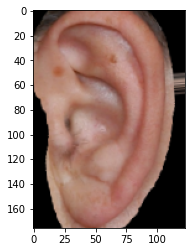

040


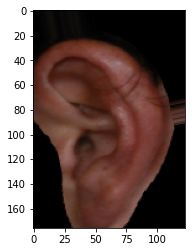

069


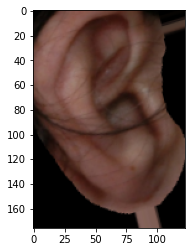

In [ ]:
n = 3
x,y = train_generator.next()
# x,y = test_generator2.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

##CUSTOM NET

In [ ]:
def custom_net(input_shape, num_classes):
    model = Sequential()
    # provare con max pooling
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))
    # model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')) # AveragePooling2D / MaxPooling2D
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid')) # ho già provato sigmoid, 75% accuracy, softmax 60% accuracy

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return model
 
# create the model
transfer_model = custom_net(input_shape, num_classes)
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 123, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 61, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 59, 16)        1168      
                                                                 
 batch_normalization (BatchN  (None, 86, 59, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 29, 16)       0         
 2D)                                                             
                                                        

##Train the model

In [ ]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 500
# callbacks=[stopping],\
try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


# Save trained model and hystory
problemname = 'CUSTOM_NET-500ep_b64_MaxP_DBCrop'
# problemname = 'CUSTOM_NET-750ep_b64_MaxP' //ultima
savemodel(transfer_model,problemname)
savehistory(transfer_history,problemname)

Epoch 1/500
15/15 [==============================] - 381s 26s/step - loss: 5.0509 - accuracy: 0.0246 - val_loss: 4.5934 - val_accuracy: 0.0125
Epoch 2/500
15/15 [==============================] - 28s 2s/step - loss: 4.2124 - accuracy: 0.0759 - val_loss: 4.5791 - val_accuracy: 0.0150
Epoch 3/500
15/15 [==============================] - 28s 2s/step - loss: 3.6794 - accuracy: 0.1485 - val_loss: 4.5677 - val_accuracy: 0.0150
Epoch 4/500
15/15 [==============================] - 28s 2s/step - loss: 3.2270 - accuracy: 0.1987 - val_loss: 4.5524 - val_accuracy: 0.0100
Epoch 5/500
15/15 [==============================] - 28s 2s/step - loss: 2.8357 - accuracy: 0.3120 - val_loss: 4.5334 - val_accuracy: 0.0125
Epoch 6/500
15/15 [==============================] - 28s 2s/step - loss: 2.5938 - accuracy: 0.3531 - val_loss: 4.5385 - val_accuracy: 0.0100
Epoch 7/500
15/15 [==============================] - 28s 2s/step - loss: 2.4237 - accuracy: 0.3979 - val_loss: 4.5342 - val_accuracy: 0.0275
Epoch 8/500

##Plot results

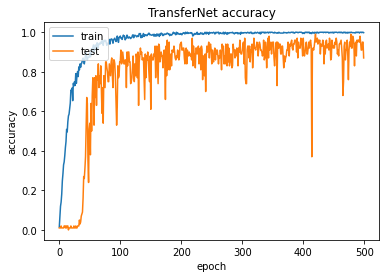

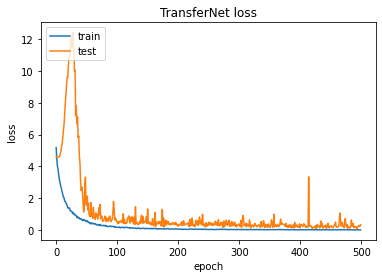

[0.014957264997065067, 0.07051282376050949, 0.11965811997652054, 0.14102564752101898, 0.1816239356994629, 0.24786324799060822, 0.28418803215026855, 0.3290598392486572, 0.3440170884132385, 0.3760683834552765, 0.4166666567325592, 0.4465811848640442, 0.5085470080375671, 0.49572649598121643, 0.5470085740089417, 0.5769230723381042, 0.5854700803756714, 0.6132478713989258, 0.6410256624221802, 0.7072649598121643, 0.7051281929016113, 0.7179487347602844, 0.6538461446762085, 0.7414529919624329, 0.7286324501037598, 0.75, 0.7307692170143127, 0.7905982732772827, 0.7414529919624329, 0.7791666388511658, 0.8012820482254028, 0.7756410241127014, 0.8247863054275513, 0.80982905626297, 0.8397436141967773, 0.8226495981216431, 0.8397436141967773, 0.8461538553237915, 0.8604166507720947, 0.8696581125259399, 0.8589743375778198, 0.8397436141967773, 0.8611111044883728, 0.8867521286010742, 0.8974359035491943, 0.8717948794364929, 0.8589743375778198, 0.8739316463470459, 0.8739316463470459, 0.8739316463470459, 0.89529

In [ ]:
def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # plt.ylim(0.8,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.ylim(0.0,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    
name="TransferNet"
# with open("/content/drive/My Drive/Biometrics Systems/results/CUSTOM_NET-500ep_NEW.hist", "rb") as f:
#     transfer_history = pickle.load(f)
# print(transfer_history)
plot_history(transfer_history, name)
print(transfer_history.history['accuracy'])
# print("Last accuracy: %d", %history.history['accuracy'])

##Accuracy, precision, recall, F-score


In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = transfer_model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

val_steps=test_generator.n//test_generator.batch_size+1

preds = transfer_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

2/2 [==============================] - 1s 350ms/step - loss: 0.2530 - accuracy: 0.9500
Test loss: 0.252973
Test accuracy: 0.950000
2/2 [==============================] - 1s 349ms/step
              precision    recall  f1-score   support

         000      1.000     1.000     1.000         1
         001      1.000     1.000     1.000         1
         002      1.000     1.000     1.000         1
         003      1.000     1.000     1.000         1
         004      1.000     1.000     1.000         1
         005      0.000     0.000     0.000         1
         007      1.000     1.000     1.000         1
         008      1.000     1.000     1.000         1
         009      1.000     1.000     1.000         1
         010      1.000     1.000     1.000         1
         011      1.000     1.000     1.000         1
         012      1.000     1.000     1.000         1
         013      0.000     0.000     0.000         1
         014      1.000     1.000     1.000         1
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TEST DATABASE CROPPED

In [ ]:
# problemname = 'CUSTOM_NET-750ep_b64_MaxP'
problemname = 'CUSTOM_NET-500ep_b64_MaxP_DBCrop'
model = loadmodel(problemname)
val_steps=test_generator2.n//test_generator2.batch_size+1
loss, acc = model.evaluate(test_generator2,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

val_steps=test_generator2.n//test_generator2.batch_size+1

preds = model.predict(test_generator2,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator2.classes  # shuffle=False in test_generator2

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


Model loaded from file /content/drive/My Drive/Biometrics Systems/models/CUSTOM_NET-500ep_b64_MaxP_DBCrop.h5



KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


4/4 [==============================] - 1s 233ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
005              ->  104               	1 	1.00 % 
013              ->  054               	1 	1.00 % 
026              ->  063               	1 	1.00 % 
038              ->  101               	1 	1.00 % 
046              ->  072               	1 	1.00 % 
053              ->  072               	1 	1.00 % 
067              ->  051               	1 	1.00 % 
070              ->  098               	1 	1.00 % 
093              ->  009               	1 	1.00 % 
096              ->  075               	1 	1.00 % 
099              ->  075               	1 	1.00 % 
100              ->  009               	1 	1.00 % 
104              ->  076               	1 	1.00 % 
105              ->  104               	1 	1.00 % 


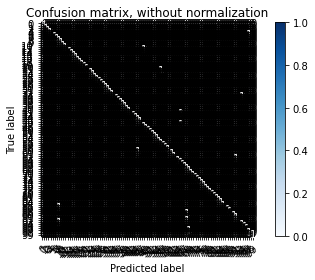

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1

preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

integer_classnames = []
for i,k in enumerate(classnames):
  integer_classnames.append(int(i))
plot_confusion_matrix(Ytest, Ypred, classes=integer_classnames, normalize=False)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])


print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

##Feature extractor


Model loaded from file /content/drive/My Drive/Biometrics Systems/models/CUSTOM_NET-500ep_b64_MaxP_DBCrop.h5

96
[-1.1877589225769043, 1.0801197290420532, -0.5576615929603577, -2.0485150814056396, -2.0027832984924316, 0.03236275911331177, -0.8878867030143738, 1.1591445207595825, -2.5826401710510254, -1.364197015762329, -0.3025478422641754, -0.8303015828132629, 2.3685243129730225, -0.005885403603315353, -3.1984379291534424, -0.9032039046287537, 1.8774604797363281, -1.2788954973220825, -1.572319746017456, 0.5764315128326416, 0.5784220099449158, -0.8059694766998291, -0.6722036600112915, -0.003856508294120431, 2.1397221088409424, 3.67340350151062, 2.448066234588623, 0.5217903256416321, 0.3834945857524872, 0.9694128632545471, -0.7109750509262085, -1.9174621105194092, 1.1794360876083374, 0.7159233689308167, 0.8558857440948486, 1.5460267066955566, -2.43013334274292, -3.647350549697876, -2.7602667808532715, 1.0913029909133911, 0.4883791506290436, 1.1902015209197998, 1.9677883386611938, 2.5175

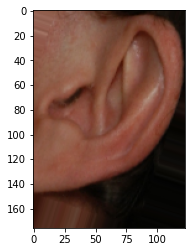

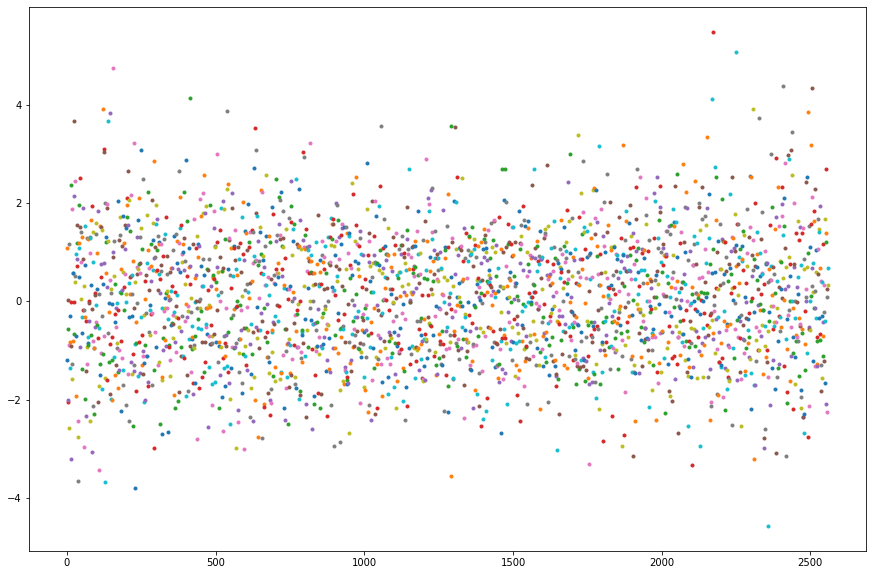

In [ ]:
# problemname = 'CUSTOM_NET-750ep_b64_MaxP'
problemname = 'CUSTOM_NET-500ep_b64_MaxP_DBCrop'
model = loadmodel(problemname)
flat_layer = model.get_layer("flatten")
feature_extractor = keras.Model(inputs=model.input, outputs=flat_layer.output)

batch_images, true_labels = train_generator.next()    # restituisce un batch da 64
single_image = batch_images[0]                       # prendo la prima immagine dalla batch
plt.imshow(single_image)
single_image = np.expand_dims(single_image, axis=0)  # devo aumentare la dimensione per compatibilità col modello
true_label = true_labels[0].argmax()
print(true_label)

feature_vector = feature_extractor(single_image)
feature_vector = feature_vector.numpy()[0]           # converto da tensore a numpy array

print(feature_vector.tolist())
print(feature_vector.shape)

plt.figure(figsize=[15, 10])
for i, val in enumerate(feature_vector.tolist()):
  plt.plot(i, val, ".")
plt.show()



Model loaded from file /content/drive/My Drive/Biometrics Systems/models/CUSTOM_NET-750ep_b64_MaxP.h5

0
[-0.5726845860481262, 0.39711594581604004, -0.5109745860099792, -2.259932041168213, 0.6005840301513672, -0.44018295407295227, 1.5284647941589355, -0.09550131857395172, -0.7557471990585327, -1.1668524742126465, -0.9467176198959351, -1.603959321975708, 0.49674364924430847, -1.7064366340637207, -0.7215659618377686, -0.4401613175868988, -1.3809133768081665, -0.015585827641189098, -0.06970997154712677, 1.4393157958984375, -1.0937390327453613, 0.1741652488708496, 0.31465238332748413, -0.05754227191209793, -0.028428899124264717, -0.15754833817481995, -0.1814473271369934, -0.18896226584911346, 1.592175841331482, -0.19445767998695374, -1.7469136714935303, -0.4585752785205841, -0.3015822768211365, -0.3617604970932007, -0.13302446901798248, -1.0915158987045288, 0.4725276231765747, 0.8158730864524841, -0.3323230445384979, 0.8129892349243164, 2.17221736907959, 1.4788168668746948, 0.940759897232

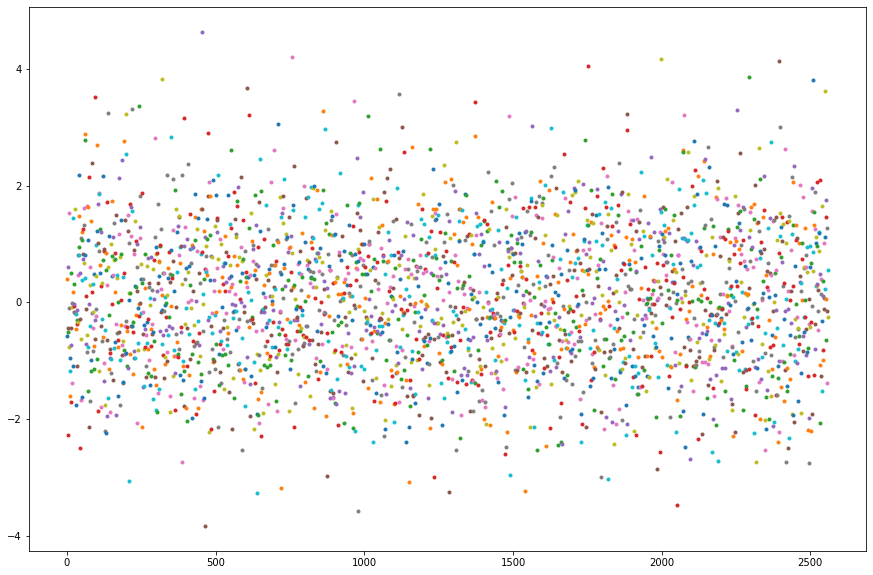

In [ ]:
problemname = 'CUSTOM_NET-750ep_b64_MaxP'
#problemname = 'CUSTOM_NET-500ep_b64_MaxP_DBCrop'
model = loadmodel(problemname)
flat_layer = model.get_layer("flatten")
feature_extractor_no_crop = keras.Model(inputs=model.input, outputs=flat_layer.output)

batch_images, true_labels = test_generator.next()    # restituisce un batch da 64
single_image = batch_images[0]                       # prendo la prima immagine dalla batch
single_image = np.expand_dims(single_image, axis=0)  # devo aumentare la dimensione per compatibilità col modello
true_label = true_labels[0].argmax()
print(true_label)

feature_vector = feature_extractor_no_crop(single_image)
feature_vector = feature_vector.numpy()[0]           # converto da tensore a numpy array

print(feature_vector.tolist())
print(feature_vector.shape)

plt.figure(figsize=[15, 10])
for i, val in enumerate(feature_vector.tolist()):
  plt.plot(i, val, ".")
plt.show()


In [ ]:


## definition function for measure distance from feature vector

# Return Pearson product-moment correlation coefficients (similarity bigger better).
def coefficient_of_correlation(fv1, fv2):
  return corrcoef(fv1,fv2)

def cosine_similarity(fv1, fv2):
  return 1 - spatial.distance.cosine(fv1, fv2)

# distances (smaller better)
def euclidean_distance(fv1,fv2):
  return spatial.distance.euclidean(fv1,fv2)

def minkowski_distances(fv1,fv2):
  return spatial.distance.minkowski(fv1,fv2)

--------------------------------------------------------------------------------

#EVALUATION

##Feature extraction

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [176, 123])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [ ]:
# load image via tf.io
img_1 = tf.io.read_file(testset_dir + '/000/000_back_ear.png')
img_2 = tf.io.read_file(testset_dir + '/000/000_front_ear.png')

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor_1 = tf.io.decode_image(img_1, channels=3, dtype=tf.dtypes.float32)
tensor_2 = tf.io.decode_image(img_2, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)

# resize tensor to 224 x 224
tensor_1 = tf.image.resize(tensor_1, [176, 123])
tensor_2 = tf.image.resize(tensor_2, [176, 123])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
input_tensor_1 = tf.expand_dims(tensor_1, axis=0)
input_tensor_2 = tf.expand_dims(tensor_2, axis=0)

# summarize some details about the image
feature_vector_1 = feature_extractor(input_tensor_1)
feature_vector_1 = feature_vector_1.numpy()[0]

feature_vector_2 = feature_extractor(input_tensor_2)
feature_vector_2 = feature_vector_2.numpy()[0]

print(feature_vector_1)
print(feature_vector_2)


##Convert all images in feature_vector (CROP)

In [ ]:
def dataset_to_feature_vector(path):
  
  feature_vectors = []
  directory_contents = os.listdir(datadir + path)

  for dir in directory_contents:

    subdir_contents = os.listdir(datadir + path + dir)
    for img in subdir_contents:
  
      if 'png' in img or 'jpeg' in img or 'jpg' in img:
        # load image via tf.io
        img = tf.io.read_file(datadir + path + dir + '/' + img)

        # set the dtypes to align with pytorch for comparison since it will use uint8 by default
        tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)

        # resize tensor to 224 x 224
        tensor= tf.image.resize(tensor, [176, 123])

        # add another dimension at the front to get NHWC shape
        input_tensor = tf.expand_dims(tensor, axis=0)

        # summarize some details about the image
        feature_vector = feature_extractor(input_tensor)
        feature_vectors.append(feature_vector.numpy().tolist()[0])

        #print(type(feature_vector.numpy().tolist()))

  return feature_vectors

##Convert all images in feature_vector (NO_CROP)

In [ ]:
def dataset_to_feature_vector_no_crop(path):
  
  feature_vectors = []
  directory_contents = os.listdir(datadir + path)

  for dir in directory_contents:

    subdir_contents = os.listdir(datadir + path + dir)
    for img in subdir_contents:
  
      if 'png' in img or 'jpeg' in img or 'jpg' in img:
        # load image via tf.io
        img = tf.io.read_file(datadir + path + dir + '/' + img)

        # set the dtypes to align with pytorch for comparison since it will use uint8 by default
        tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)

        # resize tensor to 224 x 224
        tensor= tf.image.resize(tensor, [176, 123])

        # add another dimension at the front to get NHWC shape
        input_tensor = tf.expand_dims(tensor, axis=0)

        # summarize some details about the image
        feature_vector = feature_extractor_no_crop(input_tensor)
        feature_vectors.append(feature_vector.numpy().tolist()[0])

        #print(type(feature_vector.numpy().tolist()))

  return feature_vectors

##Similarity Matrix

In [ ]:
from scipy import stats
from numpy import corrcoef
from scipy import spatial

def sim_matrix(features, measure='correlation'):

  similarityMatrix = []

  for feature in features:
    if (measure == 'cosine'):
      similarityMatrix.append(np.array([cosine_similarity(feature, x) for x in features]))
    if (measure == 'spearmanr'):
      rho, pval = stats.spearmanr(features, axis=1)
      return rho
    else:
      return corrcoef(features)

  return np.array(similarityMatrix)

In [ ]:
dist_matrix_corr_AMI = sim_matrix(dataset_to_feature_vector('/testset/'), 'correlation')
dist_matrix_corr_AMI.shape

(1400, 1400)

In [ ]:
dist_matrix_cosine_AMI = sim_matrix(dataset_to_feature_vector('/testset/'), 'cosine')
dist_matrix_cosine_AMI.shape

(1400, 1400)

In [ ]:
dist_matrix_spear_AMI = sim_matrix(dataset_to_feature_vector('/testset/'), 'spearmanr')
dist_matrix_spear_AMI.shape

(1400, 1400)

##CROP

In [ ]:
dist_matrix_corr_AMI_no_crop = sim_matrix(dataset_to_feature_vector_no_crop('/AMI_cropped/'), 'correlation')
dist_matrix_corr_AMI_no_crop.shape

(600, 600)

In [ ]:
dist_matrix_cosine_AMI_no_crop = sim_matrix(dataset_to_feature_vector('/AMI_cropped/'), 'correlation')
dist_matrix_cosine_AMI_no_crop.shape

(600, 600)

In [ ]:
dist_matrix_spear_AMI_no_crop = sim_matrix(dataset_to_feature_vector('/AMI_cropped/'), 'spearmanr')
dist_matrix_spear_AMI_no_crop.shape

(600, 600)

##Confusion Matrix

In [ ]:
def confusion_matrix(threshold, sim_matrix, n_identities=100, n_templates=14):
  import numpy as np
  conf_matrix = np.zeros((2,2)) #[[ GA FR ]
                                # [ FA GR ]]
  nrows = sim_matrix.shape[0]
  ids = range(0, n_identities)
  for row in range(nrows):
    for id in ids:
      elems = np.arange(id * n_templates, (id + 1) * n_templates)
      m_label = sim_matrix[row, elems[np.where(elems!=row)]]
      if(m_label.max() > threshold):
        if(id == row//n_templates):
          conf_matrix[0,0] += 1       # GA
        else: 
          conf_matrix[1,0] += 1       # FA
      elif(id == row//n_templates):  
        conf_matrix[0,1] += 1         # FR
      else:
        conf_matrix[1,1] += 1         # GR
  
  return conf_matrix

#conf_matrix = confusion_matrix(0.5, dist_matrix[:,:], n_identities=100)

##Genuine / impostor scores

In [ ]:
def genuine_impostor_scores(sim_matrix, n_identities=100, n_templates=14):
  import numpy as np
  genuine_scores = []
  impostor_scores = []
  nrows = sim_matrix.shape[0]

  for row in range(nrows):
    for id in range(n_identities):
      elems = np.arange(id * n_templates, (id + 1) * n_templates) # index of id in the matrix
      m_label = sim_matrix[row, elems[np.where(elems!=row)]]
      if(id == row//n_templates): # genuine
        genuine_scores.append(m_label)
      else:                       # impostor
        impostor_scores.append(m_label)

  return np.array(genuine_scores).flatten(), np.array(impostor_scores).flatten()

In [ ]:
gscores, iscores = genuine_impostor_scores(dist_matrix_corr_AMI, n_identities=100, n_templates=14)
gscores.shape, iscores.shape

((18200,), (1940400,))

In [ ]:
gscores_cosine, iscores_cosine = genuine_impostor_scores(dist_matrix_cosine_AMI, n_identities=100, n_templates=14)
gscores_cosine.shape, iscores_cosine.shape

((18200,), (1940400,))

In [ ]:
gscores_spear, iscores_spear = genuine_impostor_scores(dist_matrix_spear_AMI, n_identities=100, n_templates=14)
gscores_spear.shape, iscores_spear.shape

((18200,), (1940400,))

##NO_CROP

In [ ]:
gscores_no_crop_corr, iscores_no_crop_corr = genuine_impostor_scores(dist_matrix_corr_AMI_no_crop, n_identities=100, n_templates=6)
gscores_no_crop_corr.shape, iscores_no_crop_corr.shape

((3000,), (356400,))

In [ ]:
gscores_no_crop_cosine, iscores_no_crop_cosine = genuine_impostor_scores(dist_matrix_cosine_AMI_no_crop, n_identities=100, n_templates=6)
gscores_no_crop_cosine.shape, iscores_no_crop_cosine.shape

((3000,), (356400,))

In [ ]:
gscores_no_crop_spear, iscores_no_crop_spear = genuine_impostor_scores(dist_matrix_spear_AMI_no_crop, n_identities=100, n_templates=6)
gscores_no_crop_spear.shape, iscores_no_crop_spear.shape

((3000,), (356400,))

##PYEER PLOTTING

In [ ]:
!pip install pyeer

     |████████████████████████████████| 605 kB 26.0 MB/s 


##DET(Detection error tradeoff), ROC (Receiver operating characteristic), FMR (False Match Rate), FNMR (False Non-Match Rate)

In [ ]:
from pyeer.report import generate_eer_report
from pyeer.eer_info import get_eer_stats
from pyeer.plot import *

ids = ['DATASET_CROP', 'DATASET_NO_CROP']
stats_crop = get_eer_stats(gscores, iscores, ds_scores=False)
stats_no_crop = get_eer_stats(gscores_no_crop, iscores_no_crop, ds_scores=False)

filename = '/content/drive/My Drive/Biometrics Systems/report/report.csv'
stats = [stats_crop, stats_no_crop]
generate_eer_report(stats, ids, filename)

plot_eer_stats(stats, ids, save_plots=True, lgf_size=10, dpi=1000, bins=200, save_path='/content/drive/My Drive/Biometrics Systems/report/', ext='.jpg')